In [22]:
import numpy as np
import pandas as pd
from metadata import data_type
from src.pipe_store import (
    data_loader,
    date_parser,
    clean_string_strip,
    set_data_types,
    sort_values_per_client,
    datetime2int,
    one_hot_encoder,
    label_encoder,
    combine_churns,
    feature_scaler,
    df_train_test_split,
    summerize_client_behaviour,
    sklearn_adapter
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = '/Users/Danial/Downloads/assesment_file2_churn.csv'
df = (
    data_loader(data_path, parse_dates=['MONTH_PERIOD'], date_parser=date_parser)
    .pipe(set_data_types, data_type) # optimize space & df size
    .pipe(clean_string_strip, 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY')
    .pipe(combine_churns, dtype='int8')
    .pipe(sort_values_per_client, 'MONTH_PERIOD')
)

Step: data_loader | Shape: (100056, 28) | Computation Time: 0.586209s
Step: set_data_types | Shape: (100056, 28) | Computation Time: 0.139565s
Step: clean_string_strip | Shape: (100056, 28) | Computation Time: 0.003768s
Step: sort_values_per_client | Shape: (100056, 29) | Computation Time: 22.002592s


# Problem Formulation

Lets see how much information exist in the data set


In this assessment case a customer is considered to have churned in a given month if either CHURNED_IND or COMMERCIALLY_CHURNED are set to value 1.

### Exploratory Data Analysis (EDA)

In [3]:
from src.feature_selection import total_variable_variances, variable_variances_per_client
var_matrix = variable_variances_per_client(df)
var_matrix

,CHURNED_IND,COMMERCIALLY_CHURNED,PAYMENT_IND,SAVING_IND,INVESTMENTS_IND,LENDING_IND,MORTGAGE_IND,INSURANCE_LIFE_IND,INSURANCE_NONLIFE_IND,CROSS_SELL_SCORE,...,DEBIT_CLASS,BUSINESS_VOLUME_CLASS,INVESTED_CAPITAL_CLASS,SAVINGS_CAPITAL_CLASS,MIN_FEED_CLASS,REVENUES_CLASS,PAYMENT_ACTIVITIES_CODE,TARGET,Record_Count,COMBINED_CHURN
6849612538,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.0,0.0,0.00
8434703737,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.0,0.0,0.00
5465847147,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.22,0.17,0.0,0.0,0.00
6376945954,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,...,0.00,0.00,0.08,0.00,0.00,4.98,0.25,0.0,0.0,0.00
2310295193,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.04,0.04,...,0.00,0.00,0.00,0.00,0.23,0.04,0.04,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9386078012,0.24,0.17,0.24,0.24,0.0,0.24,0.0,0.0,0.00,2.20,...,0.32,12.98,0.00,16.30,5.52,1.12,3.17,0.0,0.0,0.24
6038537607,0.25,0.23,0.25,0.25,0.0,0.00,0.0,0.0,0.00,1.01,...,0.25,4.61,0.00,2.28,0.23,0.51,0.00,0.0,0.0,0.25
2279322201,0.23,0.17,0.23,0.00,0.0,0.00,0.0,0.0,0.00,0.23,...,0.23,6.17,0.00,0.00,0.20,0.04,0.22,0.0,0.0,0.23
107886320,0.04,0.00,0.04,0.04,0.0,0.00,0.0,0.0,0.00,0.17,...,0.04,2.67,0.00,3.38,0.00,0.24,0.08,0.0,0.0,0.04


In [4]:
# Mean Variances
var_matrix.mean().sort_values(ascending=False)

SAVINGS_CAPITAL_CLASS      1.889633
BUSINESS_VOLUME_CLASS      1.464807
INVESTED_CAPITAL_CLASS     1.014171
REVENUES_CLASS             0.978359
CREDIT_CLASS               0.774656
MIN_FEED_CLASS             0.393255
PAYMENT_ACTIVITIES_CODE    0.260595
CROSS_SELL_SCORE           0.160712
DEBIT_CLASS                0.094210
COMBINED_CHURN             0.026486
SAVING_IND                 0.025814
PAYMENT_IND                0.025351
CHURNED_IND                0.023763
COMMERCIALLY_CHURNED       0.019645
PACKAGE_IND                0.019554
INVESTMENTS_IND            0.018129
INSURANCE_NONLIFE_IND      0.009211
LENDING_IND                0.004812
INSURANCE_LIFE_IND         0.004284
MORTGAGE_IND               0.002869
TARGET                     0.000000
Record_Count               0.000000
dtype: float64

In [ ]:
# total_variable_variances(df, top=6, include_label=False)

'Record_Count' & 'TARGET' should be discarded from the data set

## Some remarks over the data

* Why to summerize the data:
    * The dynamic of client behaviours is rather slow (as to the variances). Thus we can account for the final value of each variable and the most recent changes (past 6 months) in the variable. This is to capture the latest state change in the variables close to the potential churn.

    * This corrects for potential inconsistency in subscription start time is important to be taken 
    
* To prevent potential bias in the dataset we have removed the client that either rejoin or rechurn 

* In this assessment case a customer is considered to have churned in a given month if either CHURNED_IND or COMMERCIALLY_CHURNED are set to value 1.

* Column 'CHURNED_IND'? is summerized to churn_event and the time at which churn occurs to churn_time.

* If client is not churned during the 24 months churn_time is assumed to be an arbitrary date, e.g. 2013-01-01.

In [48]:
horizon = 6 # Time horizon (Even number) to find dominant recent past states per column

df_sum = (df
    .drop(['TARGET', 'Record_Count'], axis=1)
    .pipe(summerize_client_behaviour, churn_col='COMBINED_CHURN', horizon=6)
    .pipe(set_data_types, {'churn_event':'float16'})
)

Step: set_data_types | Shape: (4111, 49) | Computation Time: 0.000695s


Number of clients that rejoined [churn -> active]: 25
Number of clients with rechurned [active -> churn -> active]: 33


In [49]:
print('Class balance', dict(df_sum.churn_event.value_counts()))
res = dict(df_sum.churn_event.value_counts(normalize=True).round(4) * 100)
print(f'Class balance in % {res}')

Class balance {0.0: 3574, 1.0: 537}
Class balance in % {0.0: 86.94, 1.0: 13.059999999999999}


# Missing Values
Variables with missing values are: ACCOUNTMODEL, AGE_CLASS, HOMEBANK_COLOUR, LOYALITY

### Type of missingness:

In practice, domain experts or data managers can better argue on the type of the missingness. 

Missing Completely at Random (MCAR)-> random sampling from variable distribution

Missing at Random (MAR)-> random sampling from variable distribution or predict missing class via Logistic Regression

Missing not at Random (MNAR): Should not be imputed

### Adopted Strategy

Consider all the missingess as MNAR and proceed with feature selection. Upon importance of the variable with missigness or the missing categories we can come back and adopt another strategy 

In [50]:
from src.eda import top_columns_with_missingness
top_columns_with_missingness(df)

LOYALITY           23.009115
HOMEBANK_COLOUR    15.054569
ACCOUNTMODEL        7.009075
AGE_CLASS           5.289038
dtype: float64

In [51]:
top_columns_with_missingness(df_sum)

LOYALITY           23.327658
HOMEBANK_COLOUR    15.446363
ACCOUNTMODEL        1.775724
dtype: float64

In [52]:
df_sum = df_sum.fillna('unknown')

AGE_CLASS columns has more missing value than reported due to "Leeftijd_onbekend" label which.

# Feature Selection

From previous section we know to drop: 'Record_Count', 'TARGET'

### Time-to-Event [Kaplan-Meier] curves:

To estimate the retention curves, we use the Kaplan-Meier Estimate, definedas 

$$ \hat R(t) = \prod_{t_i \, <\, t} \frac{n_i - d_i}{n_i}$$

where $d_i$ are the number of churn events at time $t$ and $n_i$ is the number of clients at risk of churn just prior to time $t$

In [53]:
df_t2e = (
    df_sum
    .pipe(datetime2int, 'churn_time')
    .fillna('unknown')
)

Step: datetime2int | Shape: (4111, 49) | Computation Time: 0.494153s


In [54]:
df_train, df_test = (
    df_t2e.pipe(df_train_test_split, test_size=0.25)
)

In [55]:
df_train.churn_event.value_counts()
# df_test.churn_event.value_counts()

0.0    2703
1.0     404
Name: churn_event, dtype: int64

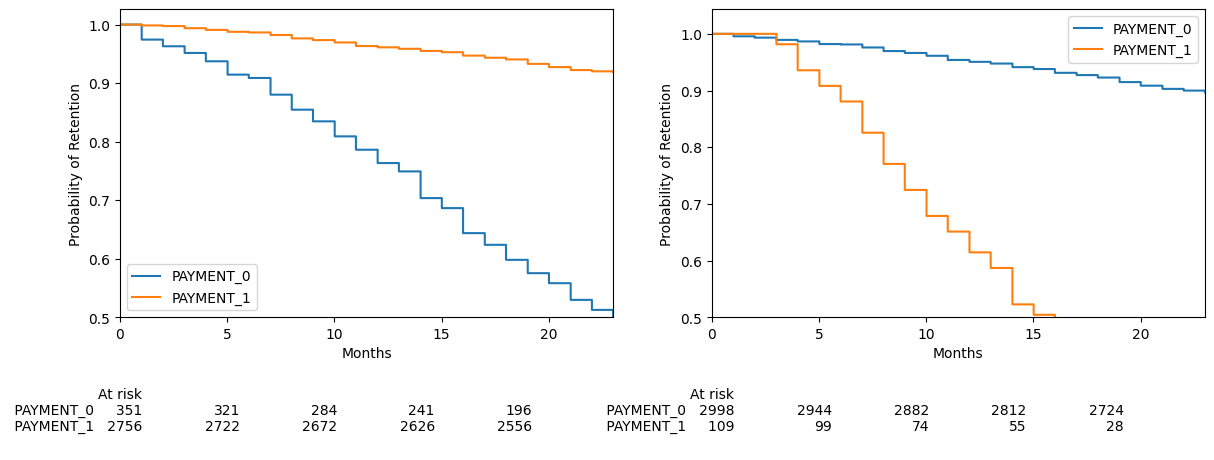

In [56]:
import matplotlib.pyplot as plt
from src.eda import plot_km_churn_risk
from lifelines import KaplanMeierFitter
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# 'INSURANCE_LIFE_IND', 'INSURANCE_NONLIFE_IND', MORTGAGE_IND', 'PACKAGE_IND', 'INVESTMENTS_IND', 'LENDING_IND', 'SAVING_IND', 'PAYMENT_INDP
plot_km_churn_risk(df_train, 'PAYMENT_IND', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'PAYMENT_IND' + '_CHANGED', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# 'SAVING_IND', 'SAVING_IND_CHANGED','PAYMENT_IND', 'PAYMENT_IND_CHANGED'

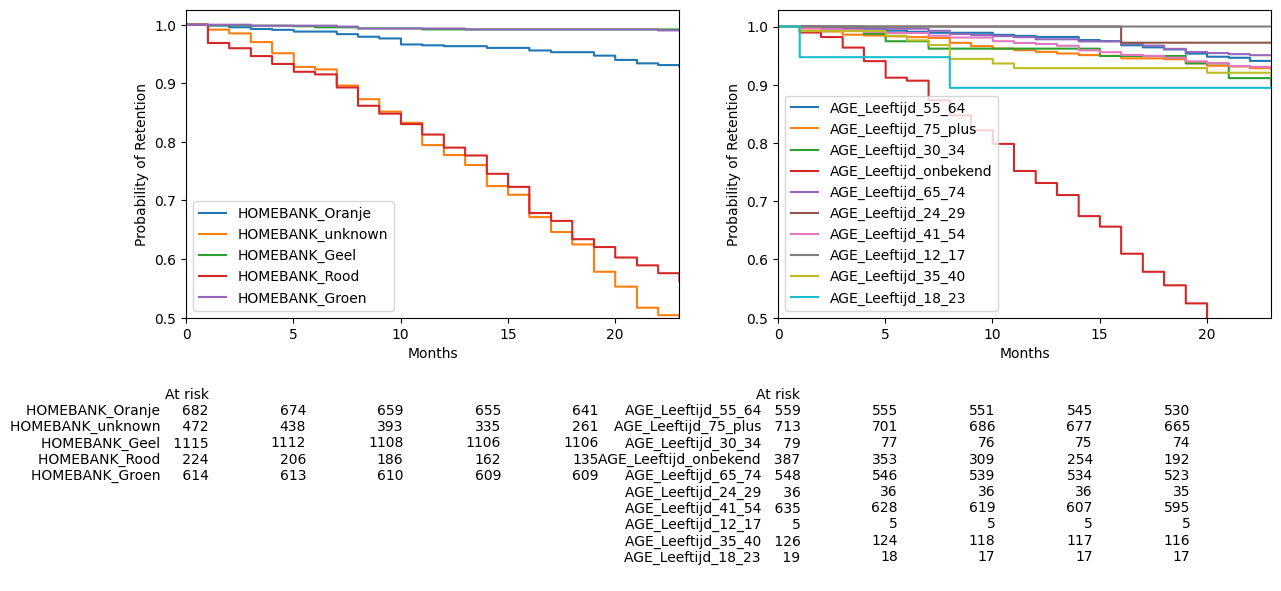

In [57]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
plot_km_churn_risk(df_train, 'HOMEBANK_COLOUR', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'AGE_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# HOMEBANK_COLOUR_unknown, HOMEBANK_COLOUR_Rood, AGE_CLASS_Leeftijd_onbekend,

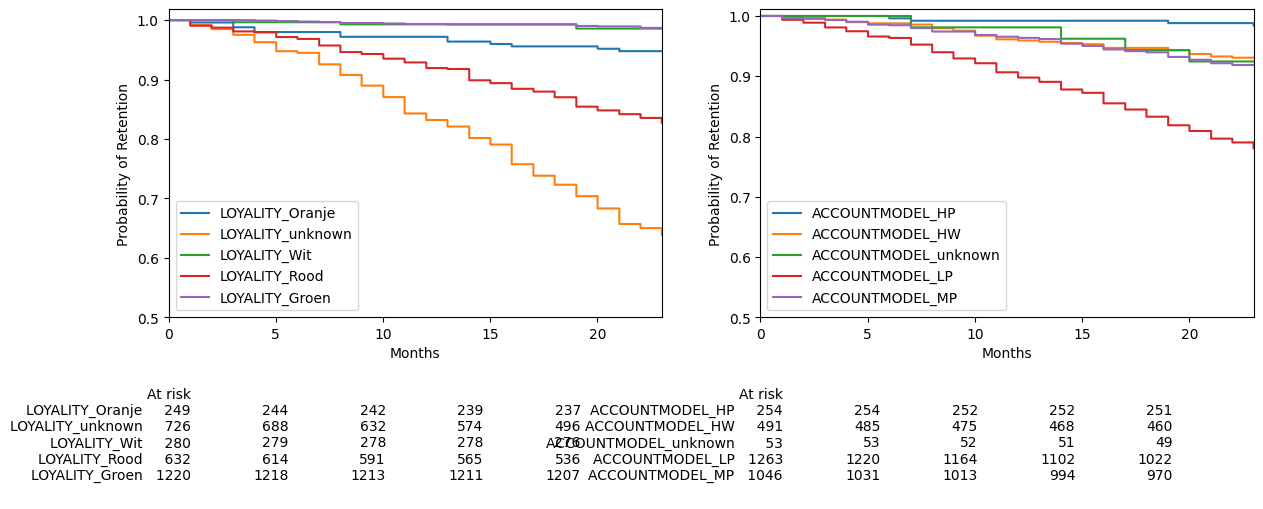

In [58]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
plot_km_churn_risk(df_train, 'LOYALITY', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'ACCOUNTMODEL', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# LOYALITY_unknown

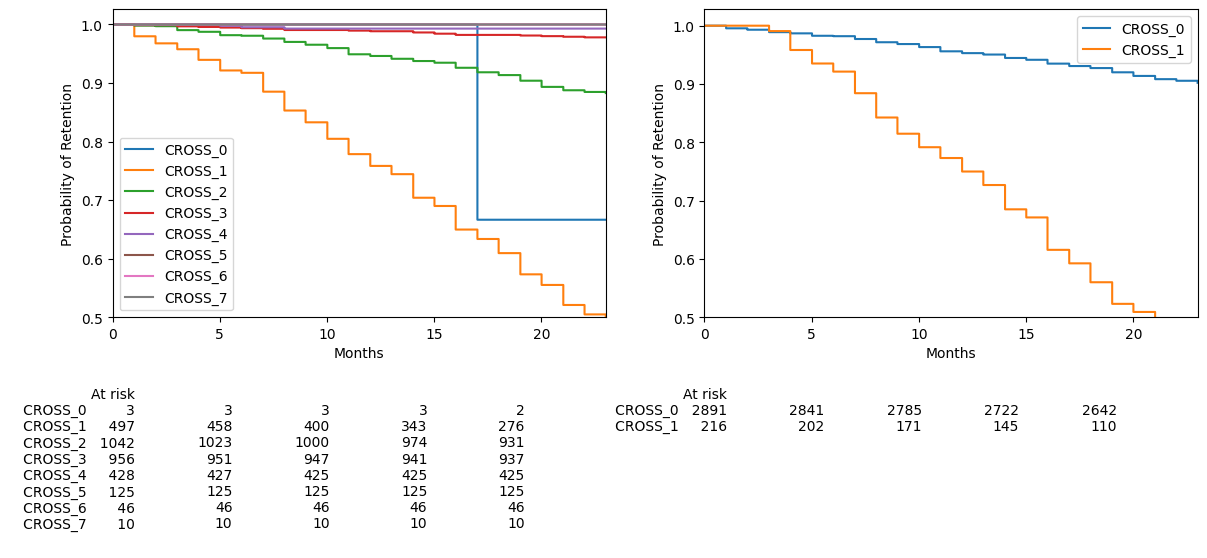

In [59]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
plot_km_churn_risk(df_train, 'CROSS_SELL_SCORE', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'CROSS_SELL_SCORE_CHANGED', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# CROSS_SELL_SCORE_1, CROSS_SELL_SCORE_CHANGED

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(14, 4))
# plot_km_churn_risk(df_train, 'CREDIT_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
# plot_km_churn_risk(df_train, 'DEBIT_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# CREDIT_CLASS_1, CREDIT_CLASS_0, DEBIT_CLASS_0

In [17]:
# fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
# plot_km_churn_risk(df_train, 'BUSINESS_VOLUME_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
# plot_km_churn_risk(df_train, 'SAVINGS_CAPITAL_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# BUSINESS_VOLUME_CLASS_1 > BUSINESS_VOLUME_CLASS_2, SAVINGS_CAPITAL_CLASS_0 > SAVINGS_CAPITAL_CLASS_2

In [18]:
# fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
# plot_km_churn_risk(df_train, 'MIN_FEED_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
# plot_km_churn_risk(df_train, 'REVENUES_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# MIN_FEED_CLASS_0, REVENUES_CLASS_3

In [19]:
# fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
# plot_km_churn_risk(df_train, 'PAYMENT_ACTIVITIES_CODE', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
# plot_km_churn_risk(df_train, 'ACCOUNTMODEL', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# ACCOUNTMODEL_LP, PAYMENT_ACTIVITIES_CODE_0

In [20]:
#'CLIENTGROUP' has ~40 categories. The promising ones were CLIENTGROUP_0101: 13%, CLIENTGROUP_0307:23 %,  CLIENTGROUP_0105: 42%
# fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
# plot_km_churn_risk(df_train, 'INVESTED_CAPITAL_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)

In [32]:
feature_selected_t2e = [
    'SAVING_IND', 'SAVING_IND_CHANGED','PAYMENT_IND', 'PAYMENT_IND_CHANGED', 'HOMEBANK_COLOUR_Rood', 'LOYALITY_unknown', 
    'AGE_CLASS_Leeftijd_onbekend', 'CROSS_SELL_SCORE_CHANGED', 'CREDIT_CLASS_1', 'CREDIT_CLASS_0', 'DEBIT_CLASS_0', 'BUSINESS_VOLUME_CLASS_1', # 'CROSS_SELL_SCORE_1', 
    'BUSINESS_VOLUME_CLASS_2', 'SAVINGS_CAPITAL_CLASS_0', 'SAVINGS_CAPITAL_CLASS_2',  'MIN_FEED_CLASS_0', 'REVENUES_CLASS_3',
    'PAYMENT_ACTIVITIES_CODE_0', 'CLIENTGROUP_0307', 'CLIENTGROUP_0105'
]

### Other Feature selection methods

In [147]:
from sklearn.model_selection import train_test_split

cat_cols = [
    'CREDIT_CLASS', 'DEBIT_CLASS', 'INVESTED_CAPITAL_CLASS', 'SAVINGS_CAPITAL_CLASS', 'MIN_FEED_CLASS', 'REVENUES_CLASS',
    'BUSINESS_VOLUME_CLASS', 'PAYMENT_ACTIVITIES_CODE', 'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY']

X, y = (
    df_sum.copy(deep=True) 
    .fillna('unknown')
    .pipe(one_hot_encoder, *cat_cols, dtype='int8')
    # .pipe(label_encoder, 'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY')
    .pipe(feature_scaler, 'CROSS_SELL_SCORE', scaler='Standard')
    .drop(['churn_time', 'id'], axis=1)
    .pipe(sklearn_adapter, label='churn_event')
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Step: feature_scaler | Shape: (4111, 169) | Computation Time: 0.001083s


In [34]:
y_test.value_counts()

0.0    908
1.0    120
Name: churn_event, dtype: int64

### Univariate Correlation

In [35]:
from src.feature_selection import select_kbest_features
col_drop = ['CROSS_SELL_SCORE']
selected_cols = select_kbest_features(X_train.drop(col_drop, axis=1), y_train, k=20)
print(selected_cols)

['BUSINESS_VOLUME_CLASS_CHANGED', 'PACKAGE_IND', 'PAYMENT_IND_CHANGED', 'SAVING_IND_CHANGED', 'CROSS_SELL_SCORE_CHANGED', 'CREDIT_CLASS_1', 'SAVINGS_CAPITAL_CLASS_0', 'SAVINGS_CAPITAL_CLASS_2', 'SAVINGS_CAPITAL_CLASS_9', 'MIN_FEED_CLASS_0', 'MIN_FEED_CLASS_1', 'BUSINESS_VOLUME_CLASS_1', 'BUSINESS_VOLUME_CLASS_8', 'PAYMENT_ACTIVITIES_CODE_0', 'AGE_CLASS_Leeftijd_onbekend', 'HOMEBANK_COLOUR_Geel', 'HOMEBANK_COLOUR_Rood', 'HOMEBANK_COLOUR_Unknown', 'LOYALITY_Groen', 'LOYALITY_Unknown']


In [36]:
from src.feature_selection import plot_corr_cat
corrs = plot_corr_cat(X_train[selected_cols], show_figure=False)

Correlations with signigicance < 0.05


### Model Based Feature Selection [Lasso]

* There are number of candidates, one of which is Lasso.

In [37]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.003)
model.fit(X_train, y_train)
feat_selc = pd.DataFrame()
feat_selc['features'] = list(X_train.columns)
feat_selc['coeficient'] = model.coef_

In [38]:
df_feat_lasso = feat_selc[feat_selc.coeficient.abs() > 0.01].sort_values(by='coeficient', ascending=True)
df_feat_lasso

,features,coeficient
31,CROSS_SELL_SCORE,-0.035067
158,HOMEBANK_COLOUR_Oranje,-0.025374
156,HOMEBANK_COLOUR_Geel,-0.024359
29,ACCOUNTMODEL_CHANGED,-0.013562
20,HOMEBANK_COLOUR_CHANGED,0.010963
164,LOYALITY_Unknown,0.011108
6,SAVINGS_CAPITAL_CLASS_CHANGED,0.011462
69,MIN_FEED_CLASS_1,0.012796
7,CREDIT_CLASS_CHANGED,0.014014
32,CROSS_SELL_SCORE_CHANGED,0.016628


In [39]:
print(len(set(df_feat_lasso.features.values)))
len(set(df_feat_lasso.features.values) & set(feature_selected_t2e))

21


9

## Multicolinearity

In [60]:
cat_cols = [
    'CREDIT_CLASS', 'DEBIT_CLASS', 'INVESTED_CAPITAL_CLASS', 'SAVINGS_CAPITAL_CLASS', 'MIN_FEED_CLASS', 'REVENUES_CLASS',
    'LOYALITY', 'BUSINESS_VOLUME_CLASS', 'PAYMENT_ACTIVITIES_CODE', 'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR']

df_corr = (
    df_train
    .pipe(one_hot_encoder, *cat_cols, dtype='int8')
    .pipe(feature_scaler, 'CROSS_SELL_SCORE', scaler='Standard')
)

Step: feature_scaler | Shape: (3107, 169) | Computation Time: 0.000832s


In [62]:
# feature_selected_t2e = [
#     'SAVING_IND', 'SAVING_IND_CHANGED','PAYMENT_IND', 'PAYMENT_IND_CHANGED', 'HOMEBANK_COLOUR_Rood', 'LOYALITY_unknown', 
#     'AGE_CLASS_Leeftijd_onbekend', 'CROSS_SELL_SCORE_CHANGED', 'CREDIT_CLASS_1', 'CREDIT_CLASS_0', 'DEBIT_CLASS_0', 'BUSINESS_VOLUME_CLASS_1', # 'CROSS_SELL_SCORE_1', 
#     'BUSINESS_VOLUME_CLASS_2', 'SAVINGS_CAPITAL_CLASS_0', 'SAVINGS_CAPITAL_CLASS_2',  'MIN_FEED_CLASS_0', 'REVENUES_CLASS_3',
#     'PAYMENT_ACTIVITIES_CODE_0', 'CLIENTGROUP_0307', 'CLIENTGROUP_0105'
# ]
print('#Featue overlap with univariate correlation', len(set(selected_cols) & set(feature_selected_t2e)))
corrs = plot_corr_cat(df_corr[feature_selected_t2e], show_figure=False) 

#Featue overlap with univariate correlation 11
Correlations with signigicance < 0.05


In [63]:
from src.eda import plot_graph
top_corrs = corrs.sort_values(ascending=True)[0:10]
plot_graph(top_corrs)

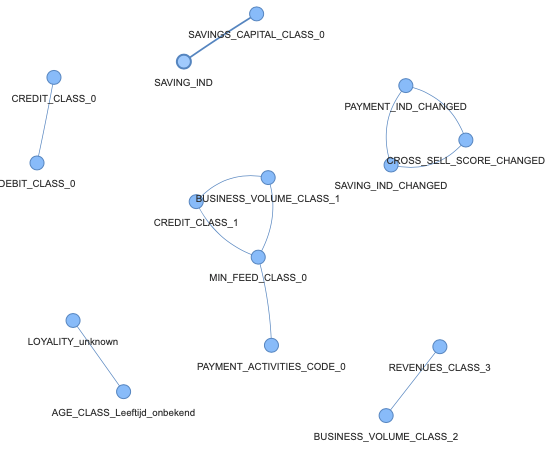

In [64]:
from IPython import display
display.Image("./graph/graph.png")
# DEBIT_CLASS_0 & CREDIT_CLASS_0
# CREDIT_CLASS_1 & BUSINESS_VOLUME_CLASS_1, MIN_FEED_CLASS_0
# LOYALITY_unknown & AGE_CLASS_Leeftijd_onbekend
# SAVING_IND & SAVING_CAPITAL_CLASS_0
# SAVING_INDEX_CHANGED & PAYMENT_IND_CHANGED & CROSS_SELL_SCORE_CHANGED

# Feature Engineering

# Seasonality [pattern in churn time]

In [ ]:
df_red[df_red.churn_event == 1]['churn_time'].value_counts().sort_index().plot.bar()


# Cox Proportional Hazard Model
Risk (hazard) of churn can be modelled via the following method

$$ h(t|x)  = b_0(t) \exp \left ( \sum_{i=1}^n b_i (x_i -\bar x)) \right) $$

Strong tool both for modelling & feature selection

In [157]:
cat_cols = [
    'CREDIT_CLASS', 'DEBIT_CLASS', 'INVESTED_CAPITAL_CLASS', 'SAVINGS_CAPITAL_CLASS', 
    'MIN_FEED_CLASS', 'REVENUES_CLASS', 'PAYMENT_ACTIVITIES_CODE', 
    'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY', ]     # 'CROSS_SELL_SCORE', 


cox_features = [
    'churn_event', 'churn_time', 
    #'SAVING_IND', #'SAVINGS_CAPITAL_CLASS_0','SAVINGS_CAPITAL_CLASS_2',
    #'SAVING_IND_CHANGED',# 'PAYMENT_IND_CHANGED', #'CROSS_SELL_SCORE_CHANGED', #'SAVING_IND_CHANGED', 
    #'PAYMENT_IND',
    'CREDIT_CLASS_0', #'DEBIT_CLASS_0',
    'CREDIT_CLASS_1', # 'BUSINESS_VOLUME_CLASS_1', # 'MIN_FEED_CLASS_0', # 'PAYMENT_ACTIVITIES_CODE_0', 
    'INVESTED_CAPITAL_CLASS_0',
    # # 'REVENUES_CLASS_3', #
    # # 'CLIENTGROUP_0105', 
    'CLIENTGROUP_0307',
    # # 'CLIENTGROUP_0101', #
    'CROSS_SELL_SCORE',
    'LOYALITY_unknown', 
    'AGE_CLASS_Leeftijd_onbekend',
    'HOMEBANK_COLOUR_unknown', 
    'HOMEBANK_COLOUR_Rood',
    'LOYALITY_Rood', 
]

In [108]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_corr[cox_features], duration_col='churn_time', event_col='churn_event')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 3107 total observations, 2703 right-censored observations>
             duration col = 'churn_time'
                event col = 'churn_event'
      baseline estimation = breslow
   number of observations = 3107
number of events observed = 404
   partial log-likelihood = -2643.31
         time fit was run = 2022-10-25 08:49:27 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
CREDIT_CLASS_0               -0.95       0.39       0.28            -1.50            -0.40                 0.22                 0.67
CREDIT_CLASS_1                0.43       1.54       0.12             0.20             0.67                 1.22                 1.95
INVESTED_CAPITAL_CLASS_0      0.95       2.58       0.30             0.37             1.53                 1.45                 4.61
CLIENTGROUP_0307              0.43       1.54       0.26            -0.08             0.94                 0.92                 2.55
CROSS_SELL_SCORE             -0.84       0.43       0.11            -1.05            -0.62                 0.35                 0.54
LOYALITY_unknown              0.99       2.70       0.25             0.51             1.48                 1.66                 4.41
AGE_CLASS_Leeftijd_onbekend   0.78       2.17       0.30             0.18             1.37                 1.20                 3.93
HOMEBANK_COLOUR_unknown       1.24       3.44       0.30             0.65             1.83                 1.91                 6.21
HOMEBANK_COLOUR_Rood          1.87       6.50       0.20             1.49             2.26                 4.42                 9.55
LOYALITY_Rood                 0.87       2.38       0.23             0.42             1.31                 1.52                 3.71

                              cmp to     z      p   -log2(p)
covariate                                                   
CREDIT_CLASS_0                  0.00 -3.41 <0.005      10.58
CREDIT_CLASS_1                  0.00  3.59 <0.005      11.54
INVESTED_CAPITAL_CLASS_0        0.00  3.20 <0.005       9.53
CLIENTGROUP_0307                0.00  1.66   0.10       3.36
CROSS_SELL_SCORE                0.00 -7.64 <0.005      45.42
LOYALITY_unknown                0.00  3.99 <0.005      13.91
AGE_CLASS_Leeftijd_onbekend     0.00  2.57   0.01       6.61
HOMEBANK_COLOUR_unknown         0.00  4.11 <0.005      14.60
HOMEBANK_COLOUR_Rood            0.00  9.54 <0.005      69.25
LOYALITY_Rood                   0.00  3.81 <0.005      12.82
---
Concordance = 0.91
Partial AIC = 5306.62
log-likelihood ratio test = 1156.02 on 10 df
-log2(p) of ll-ratio test = 801.76

## Concordance Index [C-Index]:

* C-Index: Defined as the ratio of the concordant pairs to the total comparable pairs.

* Concordant pair: the pair $(i, j)$ is concordant if churn time $t_i > t_j$ and predicted churn time $S(t_i) > S(t_j)$

* For a binary outcome, C-index is identical to the area under the ROC curve (AUC).


In [109]:
df_test_cox = (
    df_test
    .pipe(one_hot_encoder, *cat_cols, dtype='int8')
    .pipe(feature_scaler, 'CROSS_SELL_SCORE', scaler='Standard')
)

Step: feature_scaler | Shape: (1004, 147) | Computation Time: 0.000813s


In [110]:
from src.model_evaluation import  print_concordance_index
print_concordance_index(cph, df_test_cox, T='churn_time', E='churn_event')

C-index for test data is 90.43%


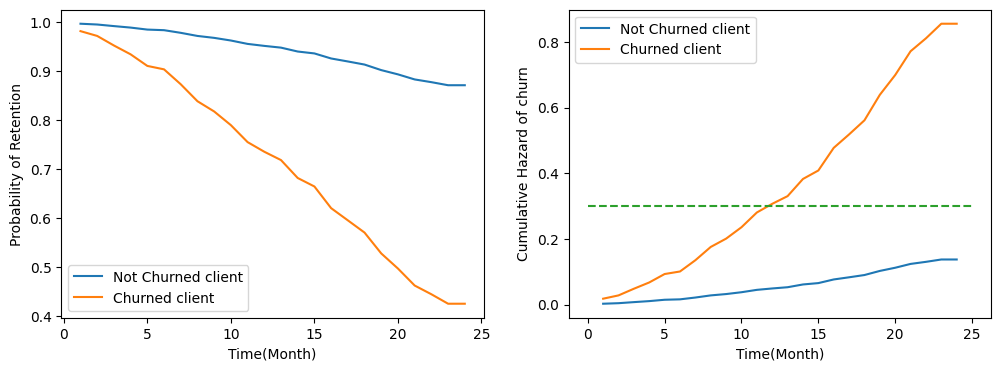

In [128]:
from src.model_evaluation import plot_cumulative_hazard_and_survival
plot_cumulative_hazard_and_survival(cph, df_test_cox, cut_off=0.3)

# Added values of Time-to-Event Modelling:

* Getting a risk profile throughout time (24 months) for each client

* Client relationship manager can do more with these graphs. Although, this should be discussed with them.

    * Above or between certain threshold specific action should be taken.

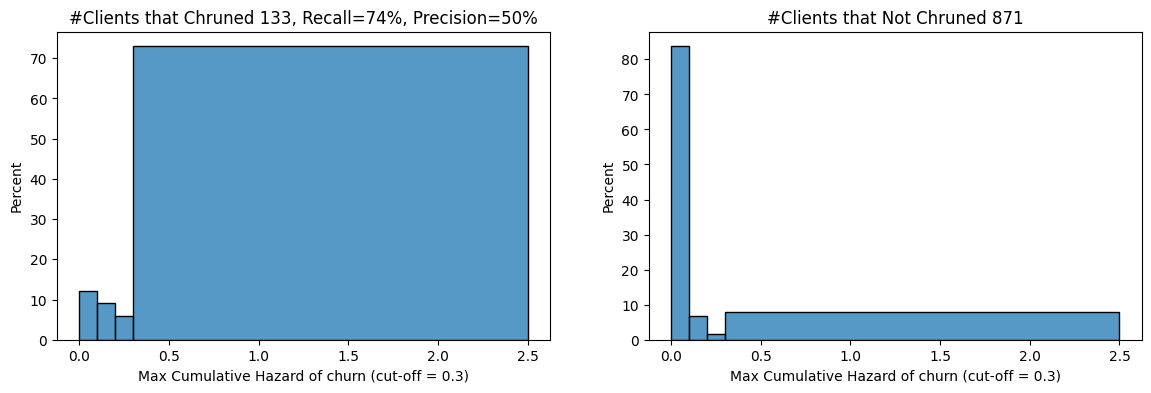

In [129]:
from src.model_evaluation import t2e_model_performance
t2e_model_performance(cph, df_test_cox)

# Classifier
### Cross Validation 

In [199]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
random_state = 42

clfs = [ LogisticRegression(), RandomForestClassifier(), GaussianNB()]
cox_features_clf = list(set(cox_features) - {'churn_time', 'churn_event'})
num_cols = ['CROSS_SELL_SCORE']
column_transformer_scaler = ColumnTransformer([
    ('Scaler', StandardScaler(), num_cols), 
], remainder='passthrough')

results = {}
for clf in clfs:

    pipeline = Pipeline([
        ('scaler', column_transformer_scaler),
        ('Model', clf),
    ], verbose=False)

    kfs = KFold(n_splits=5, shuffle=True)
    metrics = ['recall', 'precision', 'roc_auc', 'accuracy', 'f1'] 
    scores = cross_validate(pipeline, X[cox_features_clf], y, cv=kfs, scoring=metrics)
    reg_name = type(clf).__name__
    results[reg_name] = {key: round(np.mean(val), 3) for key, val in scores.items()}
pd.DataFrame(results).T

,fit_time,score_time,test_recall,test_precision,test_roc_auc,test_accuracy,test_f1
LogisticRegression,0.066,0.014,0.572,0.756,0.934,0.920,0.649
RandomForestClassifier,0.175,0.043,0.569,0.752,0.928,0.919,0.647
GaussianNB,0.005,0.011,0.807,0.525,0.919,0.879,0.636


### Train-Test Split 

In [196]:
from src.model_evaluation import (
    plot_roc_curve,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    print_scores,
)

# clf = LogisticRegression(max_iter=150) 
clf = RandomForestClassifier()
pipeline = Pipeline([
    ('scaler', column_transformer_scaler),
    ('Model', clf),
], verbose=False)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Scaler', StandardScaler(),
                                                  ['CROSS_SELL_SCORE'])])),
                ('Model', RandomForestClassifier())])

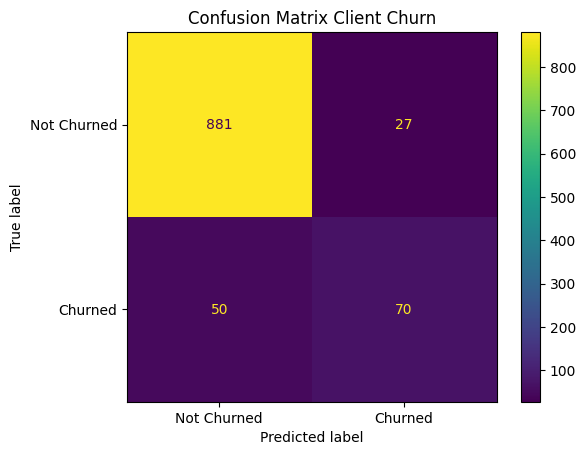

Precision/PPV := TP/(TP+FP):  0.72
Sensitivity/Recall/TPR := TP/(TP+FN):  0.58


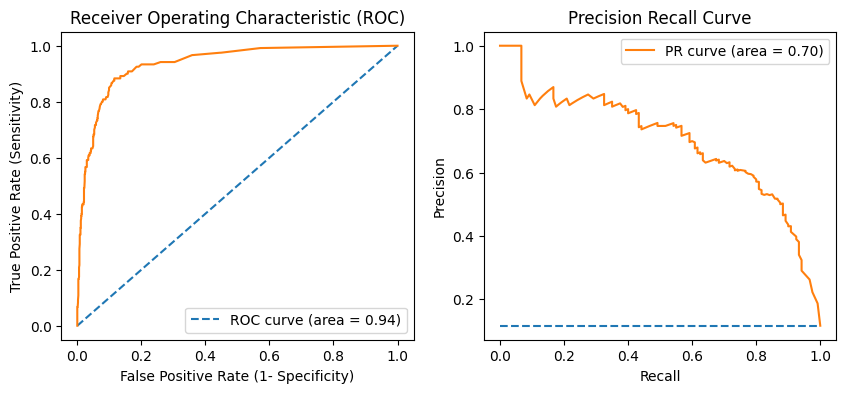

In [197]:
plot_confusion_matrix(pipeline, X_test, y_test)
print_scores(pipeline, X_test, y_test)
fig, ax = plt.subplots(1,2, figsize=(10, 4))
plot_roc_curve(pipeline, X_test, y_test, ax[0])
plot_precision_recall_curve(pipeline, X_test, y_test, ax[1])

# Conclusion & Future directions:

* 

In [ ]:
X